In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics import classification_report
from keras.regularizers import l2
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.resize(img,(224,224), interpolation = cv2.INTER_AREA)
            img = img_to_array(img)
            img = preprocess_input(img)
            images.append(img)
    return images

train=load_images_from_folder('dataset_smoking_notsmoking_splitted/training_data/notsmoking/')+load_images_from_folder('dataset_smoking_notsmoking_splitted/training_data/smoking/')
valid=load_images_from_folder('dataset_smoking_notsmoking_splitted/validation_data/notsmoking/')+load_images_from_folder('dataset_smoking_notsmoking_splitted/validation_data/smoking/')
test=load_images_from_folder('dataset_smoking_notsmoking_splitted/testing_data/notsmoking/')+load_images_from_folder('dataset_smoking_notsmoking_splitted/testing_data/smoking/')

In [4]:
len(train),len(test),len(valid)

(1608, 396, 399)

In [5]:
X_train = np.array(train)
X_test = np.array(test)
X_valid = np.array(valid)
X_train.shape,X_test.shape,X_valid.shape

((1608, 224, 224, 3), (396, 224, 224, 3), (399, 224, 224, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


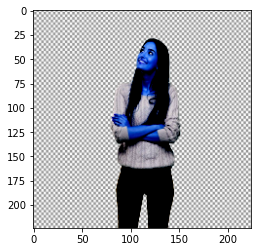

In [6]:
imshow(X_train[803])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


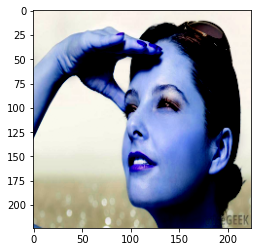

In [7]:
imshow(X_test[197])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


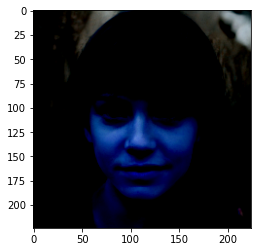

In [8]:
imshow(X_valid[199])

In [9]:
Y_train = np.concatenate((np.zeros((1,804), np.int8).T,np.ones((1,804), np.int8).T)).reshape((-1,1))
Y_test = np.concatenate((np.zeros((1,198), np.int8).T,np.ones((1,198), np.int8).T)).reshape((-1,1))
Y_valid = np.concatenate((np.zeros((1,200), np.int8).T,np.ones((1,199), np.int8).T)).reshape((-1,1))
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("number of validation examples = " + str(X_valid.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
print ("X_valid shape: " + str(X_valid.shape))
print ("Y_valid shape: " + str(Y_valid.shape))

number of training examples = 1608
number of test examples = 396
number of validation examples = 399
X_train shape: (1608, 224, 224, 3)
Y_train shape: (1608, 1)
X_test shape: (396, 224, 224, 3)
Y_test shape: (396, 1)
X_valid shape: (399, 224, 224, 3)
Y_valid shape: (399, 1)


In [10]:
# Shuffle your data here
np.random.seed(10) 
np.random.shuffle(X_train)
np.random.seed(10) 
np.random.shuffle(Y_train)

np.random.seed(20) 
np.random.shuffle(X_test)
np.random.seed(20)
np.random.shuffle(Y_test)

np.random.seed(30) 
np.random.shuffle(X_valid)
np.random.seed(30)
np.random.shuffle(Y_valid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape : (224, 224, 3) 
class: [1]


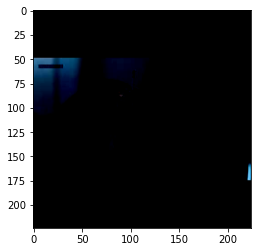

In [11]:
i= 20
print("Image shape :",X_train[i].shape,'\nclass:',Y_train[i])
imshow(X_train[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape : (224, 224, 3) 
class: [1]


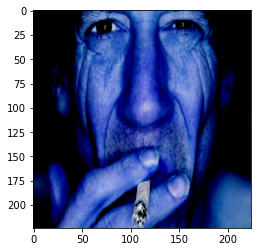

In [12]:
i= 36
print("Image shape :",X_test[i].shape,'\nclass:',Y_test[i])
imshow(X_test[i])

In [13]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [14]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# headModel = baseModel.output
# headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
# headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(128, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(1, activation="sigmoid")(headModel)
# model = Model(inputs=baseModel.input, outputs=headModel)
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(64, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

In [15]:
LR = 1e-4
EPOCHS = 100
BS = 12
model_store_dir = "smoking_model"

In [16]:
for layer in baseModel.layers:
    layer.trainable = False
opt = Adam(learning_rate=LR, decay=LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

H = model.fit(
    aug.flow(X_train, Y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_valid, Y_valid),
    validation_steps=len(X_valid) // BS,
    epochs=EPOCHS)

Epoch 1/100
134/134 [==============================] - 18s 107ms/step - loss: 1.4465 - accuracy: 0.6511 - val_loss: 1.2762 - val_accuracy: 0.7694
Epoch 2/100
134/134 [==============================] - 12s 91ms/step - loss: 1.2582 - accuracy: 0.7655
Epoch 3/100
134/134 [==============================] - 12s 91ms/step - loss: 1.1588 - accuracy: 0.7991
Epoch 4/100
134/134 [==============================] - 12s 88ms/step - loss: 1.0685 - accuracy: 0.8091
Epoch 5/100
134/134 [==============================] - 12s 86ms/step - loss: 1.0133 - accuracy: 0.8109
Epoch 6/100
134/134 [==============================] - 12s 89ms/step - loss: 0.9715 - accuracy: 0.8147
Epoch 7/100
134/134 [==============================] - 12s 89ms/step - loss: 0.8804 - accuracy: 0.8427
Epoch 8/100
134/134 [==============================] - 12s 87ms/step - loss: 0.8535 - accuracy: 0.8315
Epoch 9/100
134/134 [==============================] - 12s 88ms/step - loss: 0.7975 - accuracy: 0.8495
Epoch 10/100
134/134 [========

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       396

    accuracy                           1.00       396
   macro avg       1.00      1.00      1.00       396
weighted avg       1.00      1.00      1.00       396



F:\Files\anaconda\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


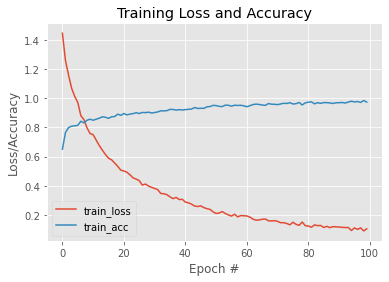

In [17]:
predIdxs = model.predict(X_test, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(Y_test.argmax(axis=1), predIdxs))

model.save(model_store_dir, save_format="h5")
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('ploy.jpg')

In [18]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test, batch_size=32)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

13/13 [==============================] - 1s 39ms/step - loss: 0.3405 - accuracy: 0.9015
Test loss: 0.3405 accuracy: 0.9015


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

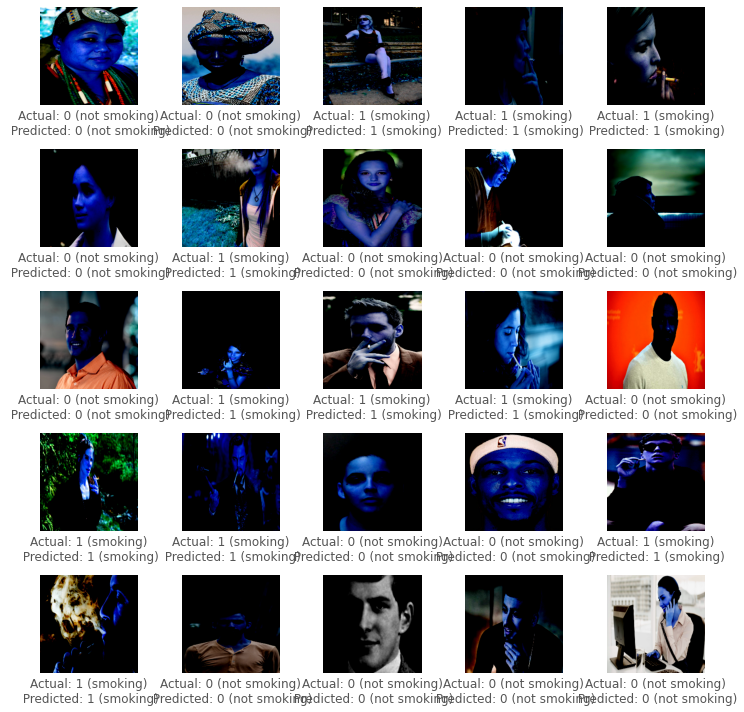

In [19]:
Y_pred=model.predict(X_test)
labels=['not smoking','smoking']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    
    img_index = np.random.randint(0, 396) 
    imshow(X_test[img_index])
    
    actual_label = round(Y_test[img_index][0])
    predicted_label = round(Y_pred[img_index][0])
    
    plt.xlabel("Actual: {} ({})\n Predicted: {} ({})".format(
        actual_label, labels[actual_label], predicted_label, labels[predicted_label]
    ))

plt.tight_layout()
plt.show()

In [5]:
cap = cv2.VideoCapture(1)

while cv2.waitKey(1) != 27:
    has_frame, img = cap.read()
    predicted=[]
    predicted.append(cv2.resize(img, (224,224)))
    if len(predicted)==1:
        pred=model.predict(np.array(predicted)/255)
        cv2.putText(img,str(pred[0][0]),(50,150),cv2.FONT_HERSHEY_COMPLEX,.8,(0,255,0),2)
        if pred[0][0]<0.1:
            cv2.putText(img,'Not smoking',(50,50),cv2.FONT_HERSHEY_COMPLEX,.8,(0,255,0),2)
        else:
            cv2.putText(img,'Smoking',(50,50),cv2.FONT_HERSHEY_COMPLEX,.8,(0,255,0),2)
    cv2.imshow('img', img)
cap.release()
cv2.destroyAllWindows()

In [3]:
from tensorflow import keras
model = keras.models.load_model('smoking_model')